# Introduction

L’objectif de ce projet est de réaliser une tâche de **classification de sentiments** à partir d’un jeu de données de tweets. Chaque tweet est associé à une étiquette de sentiment parmi trois classes : **positif**, **négatif** et **neutre**, ainsi qu’à certaines métadonnées.

L’approche suivie consiste à comparer des méthodes classiques de machine learning appliquées :

* d’une part sur des **représentations textuelles traditionnelles**,
* d’autre part sur des **représentations vectorielles (embeddings) issues d’un modèle de langage pré-entraîné (LLM)**, en particulier de type BERT.

Les performances des différents modèles seront analysées afin d’évaluer l’apport des embeddings LLM pour la classification de texte.

Le travail est structuré sous forme de questions, allant de **Q0 à Q7**, correspondant aux différentes étapes de l’analyse, de la modélisation et de la discussion des résultats.

**Ce notebook présente les étapes principales et les résultats expérimentaux du projet. Les explications théoriques et les détails méthodologiques sont développés plus en profondeur dans le rapport associé.**

##Imports et configuration de l’environnement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt') # Added for word_tokenize
nltk.download('punkt_tab') # Added to resolve LookupError
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

################
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

#baseline model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC



#########################
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset



##transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel,BertTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)


########################

# INSTALLATION DES DÉPENDANCES
import subprocess
import sys

print("Installation des dépendances pour LoRA Fine-tuning...\n")

packages = ['peft', 'bitsandbytes', 'accelerate']
for package in packages:
    try:
        __import__(package)
        print(f"{package} est déjà installé")
    except ImportError:
        print(f"Installation de {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f" {package} installé avec succès")


from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)



from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Installation des dépendances pour LoRA Fine-tuning...

peft est déjà installé
Installation de bitsandbytes...
 bitsandbytes installé avec succès
accelerate est déjà installé


##Q0 – Chargement, exploration et prétraitement des données

Dans cette première partie, nous nous concentrons sur la préparation du jeu de données de sentiment analysis. L’objectif de cette étape est de transformer les données brutes en représentations numériques exploitables par des modèles de machine learning.


In [2]:
# Téléchargement du jeu de données depuis Kaggle.
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Data source import complete.


In [3]:
# Chargement des jeux de données d’entraînement et de test à partir des fichiers CSV afin de préparer l’analyse.
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)

data_train = pd.read_csv(path+'/train.csv', encoding='latin1')
data_test = pd.read_csv(path+'/test.csv', encoding='latin1')


In [4]:
# Structure générale du dataset, les types de variables et un aperçu des données.
data_train.head()
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [5]:
# Identification et suppression des valeurs manquantes afin d’éviter des erreurs ou biais lors de l’entraînement des modèles.
print('-'*15+'the missing values are' +'-'*15)
print(data_train.isnull().sum())

data_train = data_train.dropna()
data_test = data_test.dropna()


---------------the missing values are---------------
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


In [6]:
# Suppression d'une colonne dérivée du texte original et non présente dans les données de test afin d'éviter tout biais.
data_train = data_train.drop('selected_text', axis=1)


In [7]:
#Conversion des labels de sentiment textuels en valeurs numériques exploitables par les algorithmes de machine learning.
sentiment_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

data_train['sentiment'] = data_train['sentiment'].map(sentiment_mapping)
data_test['sentiment'] = data_test['sentiment'].map(sentiment_mapping)


In [8]:
# Séparation des variables explicatives (features) de la variable cible (sentiment) pour préparer l’apprentissage supervisé.
columns_x = [col for col in data_train.columns.tolist() if col != "sentiment"]

train_x = data_train[columns_x]
train_y = data_train['sentiment']
test_x = data_test[columns_x]
test_y = data_test['sentiment']


In [9]:
# Séparation en un ensemble d’apprentissage et un ensemble de validation pour évaluer les modèles.
x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

print(type(y_train))


<class 'pandas.core.series.Series'>


In [10]:
#Affichage de la structure des données d'entrainement
print('='*50)
print('X_TRAIN SHAPE AND INFO')
print('='*50)
print(f"Shape: {x_train.shape}")
print(f"Columns: {x_train.columns.tolist()}")


X_TRAIN SHAPE AND INFO
Shape: (21984, 8)
Columns: ['textID', 'text', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']


In [11]:
# Analyse la répartition des classes de sentiment.
print('='*50)
print('Y_TRAIN TARGET INFO')
print('='*50)
print(f"Shape: {y_train.shape}")
print(f"Data type: {y_train.dtype}")
print(f"\nUnique values: {y_train.unique()}")
print(f"\nValue counts:\n{y_train.value_counts()}")
print(f"\nValue distribution (%):\n{y_train.value_counts(normalize=True) * 100}")


Y_TRAIN TARGET INFO
Shape: (21984,)
Data type: int64

Unique values: [2 1 0]

Value counts:
sentiment
1    8881
2    6894
0    6209
Name: count, dtype: int64

Value distribution (%):
sentiment
1    40.397562
2    31.359170
0    28.243268
Name: proportion, dtype: float64


In [12]:
# Supression de l’identifiant textuel textID, qui n’apporte aucune information pertinente pour la tâche de classification.
textID_train = x_train['textID']
textID_val = x_val['textID']
textID_test = test_x['textID']

x_train = x_train.drop('textID', axis=1)
x_val = x_val.drop('textID', axis=1)
test_x = test_x.drop('textID', axis=1)


In [13]:
# Comptage des modalités des variables catégorielles et suppression de la colonne Country
print(f"we have {len(x_train['Time of Tweet'].unique())} different type of time_of_tweet")
print(f"we have {len(x_train['Age of User'].unique())} different type of Age of User")
print(f"we have {len(x_train['Country'].unique())} different type of Country")

x_train = x_train.drop(['Country'], axis=1)


we have 3 different type of time_of_tweet
we have 6 different type of Age of User
we have 195 different type of Country


In [14]:
# Encodage des variables catégorielles en valeurs numériques
dic_tweet = {'morning': 0, 'noon': 1, 'night': 2}
dic_age = {'0-20': 0, '21-30': 1, '31-45': 2, '46-60': 3, '60-70': 4, '70-100': 5}
x_train['Time of Tweet'] = x_train['Time of Tweet'].map(dic_tweet)
x_train['Age of User'] = x_train['Age of User'].map(dic_age)

x_val['Time of Tweet'] = x_val['Time of Tweet'].map(dic_tweet)
x_val['Age of User'] = x_val['Age of User'].map(dic_age)

test_x['Time of Tweet'] = test_x['Time of Tweet'].map(dic_tweet)
test_x['Age of User'] = test_x['Age of User'].map(dic_age)


In [15]:
# Définition des colonnes numériques à analyser et à scaler
numeric_cols = ['Time of Tweet', 'Age of User',
                'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']


In [16]:
# Affichage d’un aperçu des données après encodage pour vérifier la transformation
x_train.head()


,text,Time of Tweet,Age of User,Population -2020,Land Area (Km²),Density (P/Km²)
21209,"Oh, he`s hilarious. I`m just commenting on th...",2,5,60461826,294140.0,206
18265,"thanks for trying I was hoping Bud Trillin,...",1,1,29136808,143350.0,203
9684,after show at our house rocked! saying goodbye...,0,0,11890784,25680.0,463
9689,up at 4:30am west coast time..gettin ready to ...,2,5,37742154,9093510.0,4
22728,My computer is SO slooowww this morning. I th...,0,0,115023,700.0,164


In [17]:
# Calcul de la corrélation entre les variables numériques et la cible
x_train_corr = x_train[numeric_cols]
x_train_corr['target'] = y_train

corr_matrix = x_train_corr.corr()  # correlation matrix
print("the corrolation with targer is \n ")
print(corr_matrix['target'].sort_values(ascending=False))


the corrolation with targer is 
 
target              1.000000
Age of User         0.009676
Time of Tweet       0.001087
Land Area (Km²)    -0.001190
Population -2020   -0.001222
Density (P/Km²)    -0.009373
Name: target, dtype: float64


In [18]:
# Suppression des colonnes numériques après analyse de corrélation (non utilisées dans la suite)
x_train = x_train.drop(numeric_cols, axis=1)
x_val = x_val.drop(numeric_cols, axis=1)
test_x = test_x.drop(numeric_cols, axis=1)


In [19]:
# Pipeline de prétraitement et vectorisation TF-IDF pour transformer le texte en features numériques

from nltk.tokenize import word_tokenize # Import word_tokenize

# Prétraitement des phrases : nettoyage, tokenisation, suppression de stopwords et stemming
def preprocess_sentences(sentences, tokenizer, stm=True):

    processed_sentences = []
    stop_words = set(stopwords.words("english"))
    stemmer = PorterStemmer()

    for sentence in sentences:
        sentence = sentence.lower()

        # URLs → <URL> au lieu de supprimer
        sentence = re.sub(r"http\S+|www\S+", "<URL>", sentence)

        # Mentions → <USER>, hashtags → garder mot
        sentence = re.sub(r"@\S+", "<USER>", sentence)
        sentence = re.sub(r"#(\w+)", r"\1", sentence)

        # Ponctuation sauf ! et ?
        punct_to_remove = string.punctuation.replace("?", "").replace("!", "")
        sentence = sentence.translate(str.maketrans("", "", punct_to_remove))

        # Supprimer les espaces multiples
        sentence = re.sub(r'\s+', ' ', sentence).strip()

        # Tokenisation
        tokens = tokenizer(sentence)

        # Suppression stopwords
        tokens = [token for token in tokens if token not in stop_words]

        # Stemming
        if stm:
            tokens = [stemmer.stem(token) for token in tokens]

        processed_sentences.append(' '.join(tokens))

    return processed_sentences

# Encodage des phrases prétraitées avec un vectorizer (TF-IDF)
def encode_sentences(sentences, vectorizer):
    x = vectorizer.fit_transform(sentences)
    encoded_sentences = x.toarray()
    return encoded_sentences, vectorizer

# Pipeline complet : prétraitement + vectorisation + transformation en DataFrame
def text_processing_pipeline(sentences, tokenizer, vectorizer, threshold=1):
    processed_texts = preprocess_sentences(sentences, tokenizer, threshold)
    encoded_texts, vectorizer = encode_sentences(processed_texts, vectorizer)
    columns = vectorizer.get_feature_names_out()
    df = pd.DataFrame(encoded_texts, columns=columns)
    return df, vectorizer




In [20]:
# Exemple d’application du pipeline sur un petit jeu de phrases
sentences = [
    "I love this product, it works perfectly!",
    "This is the worst experience I have ever had.",
    "The service was okay, nothing special.",
    "I am not happy with the results."
]

df_text, vectorizer = text_processing_pipeline(
    sentences,
    word_tokenize,
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    threshold=1
)
df_text

,ever,experi,experi ever,happi,happi result,love,love product,noth,noth special,okay,okay noth,perfectli,product,product work,result,servic,servic okay,special,work,work perfectli,worst,worst experi
0,0.000000,0.000000,0.000000,0.00000,0.00000,0.377964,0.377964,0.000000,0.000000,0.000000,0.000000,0.377964,0.377964,0.377964,0.00000,0.000000,0.000000,0.000000,0.377964,0.377964,0.000000,0.000000
1,0.447214,0.447214,0.447214,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.447214,0.447214
2,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.377964,0.377964,0.377964,0.377964,0.000000,0.000000,0.000000,0.00000,0.377964,0.377964,0.377964,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.57735,0.57735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Transformation des colonnes texte en listes pour préparer le pipeline
x_train = x_train['text'].tolist()
x_val = x_val['text'].tolist()
x_test = test_x['text'].tolist()


In [22]:
# Prétraitement + vectorisation TF-IDF sur les données d'entraînement
train_text, vectorizer = text_processing_pipeline(
    x_train,
    word_tokenize,
    TfidfVectorizer(max_features=1000, ngram_range=(1, 2)),
    threshold=1
)


In [23]:
# Prétraitement + transformation des données de validation avec le même vectorizer
val_text = preprocess_sentences(x_val, word_tokenize)
val_text = vectorizer.transform(val_text)


In [24]:
# Prétraitement + transformation des données de test avec le même vectorizer
test_text = preprocess_sentences(x_test, word_tokenize)
test_text = vectorizer.transform(test_text)


In [25]:
# Vérification des tailles des jeux de données après vectorisation
print("preprocessing is done successfully")

print(f"the size of data train is {train_text.shape} \n")
print(f"the size of data validation is {val_text.shape}\n")
print(f"the size of data test is {test_text.shape}\n")


preprocessing is done successfully
the size of data train is (21984, 1000) 

the size of data validation is (5496, 1000)

the size of data test is (3534, 1000)



In [26]:
# Conversion des matrices en DataFrame pour garantir le même type partout
val_text  = pd.DataFrame(val_text.toarray(), columns=train_text.columns)
test_text = pd.DataFrame(test_text.toarray(), columns=train_text.columns)


##Q1 – Classification du sentiment avec des modèles de machine learning classiques

À l’issue de la question Q0, les données ont été entièrement prétraitées et vectorisées. Dans cette section, nous appliquons plusieurs modèles classiques de machine learning pour la classification de sentiment et comparons leurs résultats. Un protocole expérimental commun est mis en place, incluant une recherche d’hyperparamètres et une évaluation rigoureuse des performances sur les ensembles d’entraînement, de validation et de test.

In [27]:
# Recherche du meilleur modèle avec GridSearchCV
def best_model(model, param_grid, x_train, y_train):
    grid = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )
    grid.fit(x_train, y_train)
    rapport = {
        'best_model': grid.best_estimator_,
        'best_patameters': grid.best_params_
    }
    return rapport


In [28]:
# Évaluation du modèle sur train et validation
def model_evaluation(model, x_train, y_train, x_val, y_val):
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)

    print("=== Train ===")
    print(classification_report(y_train, y_train_pred))

    print("=== Validation ===")
    print(classification_report(y_val, y_val_pred))

    return (
        f1_score(y_train, y_train_pred, average='weighted'),
        f1_score(y_val, y_val_pred, average='weighted')
    )


In [29]:
# Évaluation finale du modèle sur le jeu de test
def model_test(model, x_test, y_test):
    y_test_pred = model.predict(x_test)

    print("=== Test ===")
    print(classification_report(y_test, y_test_pred))

    return f1_score(y_test, y_test_pred, average='weighted')


In [30]:
# Pipeline complet : recherche du meilleur modèle + évaluation train/val/test
def pipline_model(model, param_grid, x_train, y_train, x_val, y_val, x_test, y_test):
    rapport = best_model(model, param_grid, x_train, y_train)
    model = rapport['best_model']

    train_score, val_score = model_evaluation(model, x_train, y_train, x_val, y_val)
    test_score = model_test(model, x_test, y_test)

    return train_score, val_score, test_score


In [31]:
# Initialisation d'un dictionnaire pour stocker les scores de chaque modèle
models_score = {}


In [32]:
# Modèle 1 : Logistic Regression + recherche des meilleurs hyperparamètres

lr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)

param_grid = {
    'C': [0.1, 1, 10],   # régularisation
    'penalty': ['l2']
}

train_score, val_score, test_score = pipline_model(
    lr, param_grid,
    train_text, y_train,
    val_text, y_val,
    test_text, test_y
)

models_score['LogisticRegression'] = {
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

print("Train F1:", train_score)
print("Validation F1:", val_score)
print("Test F1:", test_score)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
=== Train ===
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      6209
           1       0.66      0.79      0.72      8881
           2       0.80      0.73      0.76      6894

    accuracy                           0.73     21984
   macro avg       0.74      0.72      0.72     21984
weighted avg       0.73      0.73      0.72     21984

=== Validation ===
              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1572
           1       0.63      0.75      0.69      2236
           2       0.77      0.71      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.68      5496
weighted avg       0.69      0.69      0.69      5496

=== Test ===
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1001
           1       0.63

In [33]:
# Modèle 2 : SVM linéaire (LinearSVC) + recherche des meilleurs hyperparamètres
# (la version kernel aurait pris trop de temps)

svmLinear_model = LinearSVC(max_iter=5000)

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

train_score, val_score, test_score = pipline_model(
    svmLinear_model, param_grid,
    train_text, y_train,
    val_text, y_val,
    test_text, test_y
)

models_score['LinearSVC'] = {
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

print("Train F1:", train_score)
print("Validation F1:", val_score)
print("Test F1:", test_score)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
=== Train ===
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      6209
           1       0.69      0.74      0.71      8881
           2       0.77      0.77      0.77      6894

    accuracy                           0.73     21984
   macro avg       0.73      0.72      0.73     21984
weighted avg       0.73      0.73      0.73     21984

=== Validation ===
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1572
           1       0.66      0.71      0.68      2236
           2       0.75      0.77      0.76      1688

    accuracy                           0.70      5496
   macro avg       0.70      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496

=== Test ===
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      1001
           1       0.

In [34]:
# Modèle 3 : Multinomial Naive Bayes + recherche des meilleurs hyperparamètres

nb_model = MultinomialNB()

param_grid = {
    "alpha": [0.5, 1.0, 2.0]
}

train_score, val_score, test_score = pipline_model(
    nb_model, param_grid,
    train_text, y_train,
    val_text, y_val,
    test_text, test_y
)

models_score['MultinomialNB'] = {
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

print("Train F1:", train_score)
print("Validation F1:", val_score)
print("Test F1:", test_score)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
=== Train ===
              precision    recall  f1-score   support

           0       0.78      0.52      0.63      6209
           1       0.59      0.83      0.69      8881
           2       0.79      0.61      0.69      6894

    accuracy                           0.67     21984
   macro avg       0.72      0.65      0.67     21984
weighted avg       0.71      0.67      0.67     21984

=== Validation ===
              precision    recall  f1-score   support

           0       0.72      0.47      0.57      1572
           1       0.56      0.79      0.65      2236
           2       0.76      0.59      0.67      1688

    accuracy                           0.64      5496
   macro avg       0.68      0.62      0.63      5496
weighted avg       0.67      0.64      0.63      5496

=== Test ===
              precision    recall  f1-score   support

           0       0.74      0.51      0.60      1001
           1       0.57

In [35]:
# Modèle 4 : Random Forest + recherche des meilleurs hyperparamètres

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced'
)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 50]
}

train_score, val_score, test_score = pipline_model(
    rf_model, param_grid_rf,
    train_text, y_train,
    val_text, y_val,
    test_text, test_y
)

models_score['RandomForestClassifier'] = {
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

print("Train F1:", train_score)
print("Validation F1:", val_score)
print("Test F1:", test_score)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
=== Train ===
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6209
           1       0.96      0.98      0.97      8881
           2       0.99      0.97      0.98      6894

    accuracy                           0.97     21984
   macro avg       0.98      0.97      0.97     21984
weighted avg       0.97      0.97      0.97     21984

=== Validation ===
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1572
           1       0.66      0.71      0.68      2236
           2       0.73      0.77      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.70      0.69      5496

=== Test ===
              precision    recall  f1-score   support

           0       0.70      0.63      0.67      1001
           1       0.65

Préparation de fonctions d'affichage pour les comparaisons graphiques


In [36]:
#Transforme le dictionnaire models_score en listes utilisables pour les graphiques.
def prepare_scores(score_dict):

    models = []
    train_f1 = []
    val_f1 = []
    test_f1 = []

    for model, scores in score_dict.items():
        models.append(model)
        train_f1.append(scores['train_score'])
        val_f1.append(scores['val_score'])
        test_f1.append(scores['test_score'])

    return models, train_f1, val_f1, test_f1


In [37]:

#Affiche un graphique comparatif Train vs Validation F1-score.def plot_train_val(models, train_f1, val_f1):
def plot_train_val(models, train_f1, val_f1):

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10,6))

    bars1 = plt.bar(x - width/2, train_f1, width, label='Train F1', color='#4CAF50')
    bars2 = plt.bar(x + width/2, val_f1, width, label='Validation F1', color='#FF9800')

    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)

    plt.ylabel("F1-score", fontsize=12)
    plt.ylim(0,1)
    plt.xticks(x, models, fontsize=11)
    plt.title("Comparison of Train vs Validation F1-score by Model", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [38]:
#Affiche un graphique comparatif Test F1-score.

def plot_test(models, test_f1):

    x = np.arange(len(models))
    width = 0.5

    plt.figure(figsize=(10,6))
    bars = plt.bar(x, test_f1, width=width)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=11)

    plt.ylim(0, 1)
    plt.xticks(x, models, fontsize=12)
    plt.ylabel("F1-score", fontsize=12)
    plt.title("Test F1-score Comparison Across Models", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


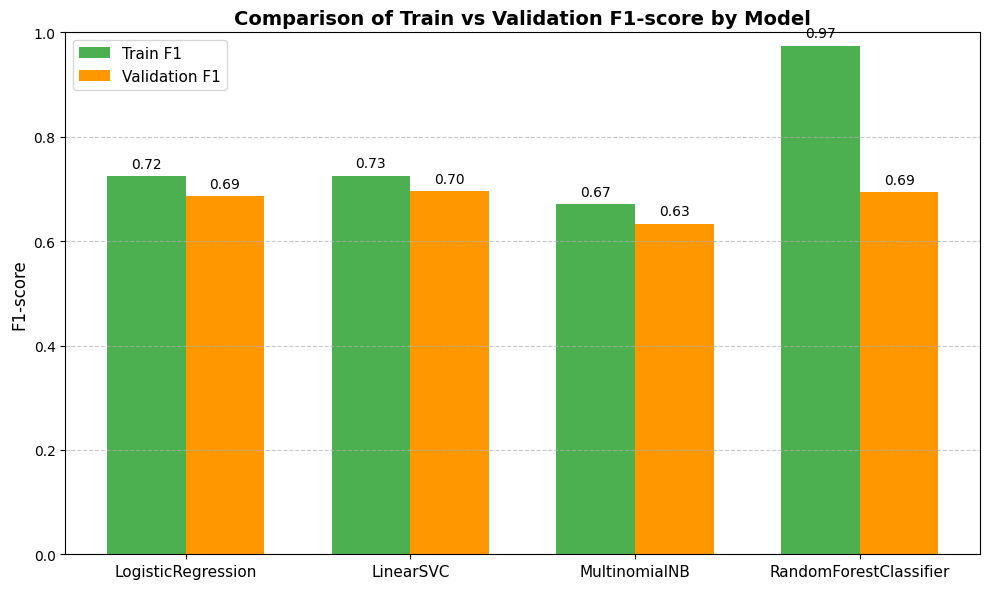

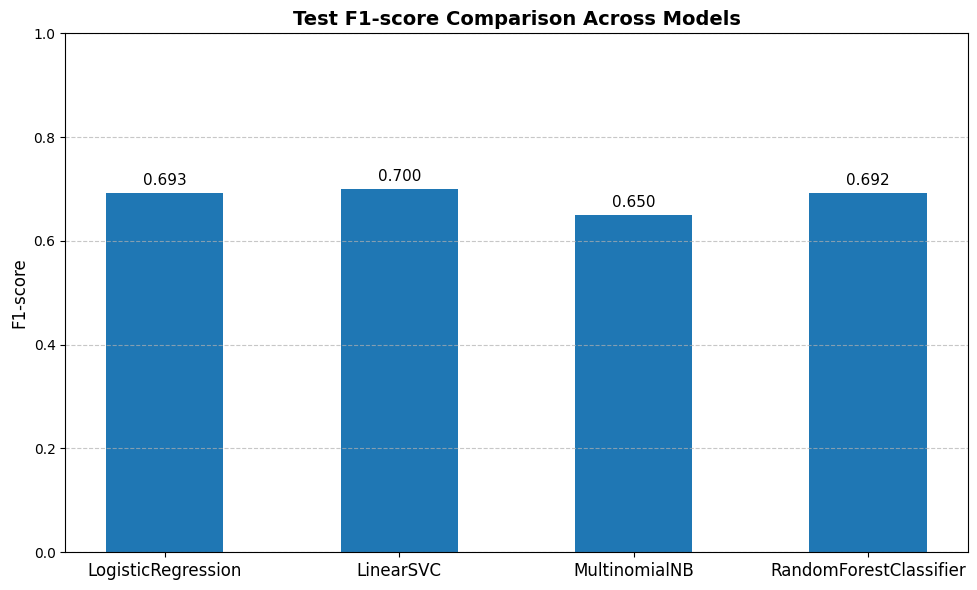

In [39]:
models, train_f1, val_f1, test_f1 = prepare_scores(models_score)

plot_train_val(models, train_f1, val_f1)
plot_test(models, test_f1)


Conservons le meilleur modèle pour les comparaisons futures.

In [40]:
best_classic_model_name = max(models_score, key=lambda m: models_score[m]['val_score'])


##Q2 – Classification avec un réseau de neurones (MLP)

Après avoir évalué plusieurs modèles de machine learning classiques dans la question précédente, nous étudions maintenant l’apport d’un modèle neuronal. L’objectif est d’analyser si un perceptron multicouche (MLP), capable de modéliser des relations non linéaires, permet d’améliorer les performances de classification du sentiment.

###Q2.1 – MLP appliqué aux représentations textuelles classiques

Dans cette première partie, nous entraînons un MLP sur les représentations vectorisées du texte utilisées précédemment (par exemple TF-IDF). Cette approche permet d’évaluer l’impact de la non-linéarité introduite par un réseau de neurones, tout en conservant les mêmes caractéristiques d’entrée que les modèles classiques de la Q1.

In [41]:
# Modèle MLP : définition + recherche d'hyperparamètres avec GridSearchCV
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    batch_size=128,
    max_iter=20,
    early_stopping=True,
    random_state=42
)

param_grid = {
    "hidden_layer_sizes": [(128,64), (256,128),(256,128,64)],
    "alpha": [1e-4, 1e-3]
}

train_score, val_score, test_score = pipline_model(
    mlp_model, param_grid,
    train_text.astype('float32'), y_train,
    val_text.astype('float32'), y_val,
    test_text.astype('float32'), test_y
)

models_score['MLP'] = {
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

print("Train F1:", train_score)
print("Validation F1:", val_score)
print("Test F1:", test_score)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
=== Train ===
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      6209
           1       0.68      0.79      0.73      8881
           2       0.80      0.77      0.78      6894

    accuracy                           0.74     21984
   macro avg       0.76      0.73      0.74     21984
weighted avg       0.75      0.74      0.74     21984

=== Validation ===
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      1572
           1       0.64      0.74      0.69      2236
           2       0.75      0.74      0.75      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496

=== Test ===
              precision    recall  f1-score   support

           0       0.71      0.61      0.66      1001
           1       0.63

###Q2.2 – MLP appliqué aux embeddings BERT

Nous utilisons ensuite un MLP entraîné sur des embeddings BERT pré-entraînés et figés. L’objectif est d’analyser si une représentation sémantique riche, issue d’un modèle de langage pré-entraîné, améliore les performances de classification lorsqu’elle est exploitée par un réseau de neurones simple

In [42]:
# Nettoyage des textes pour les LLMs
# Convertir les textes en minuscules, remplacer URLs et mentions, puis convertir les labels en listes.

def clean_text(sentences):
    clean_sentences = []
    for sentence in sentences:
        # Lowercase
        sentence = sentence.lower()

        # Remplacer URLs
        sentence = re.sub(r'http\S+|www\S+', '<URL>', sentence)

        # Remplacer mentions
        sentence = re.sub(r'@\w+', '<USER>', sentence)

        # Supprimer le '#' des hashtags
        sentence = re.sub(r'#(\w+)', r'\1', sentence)

        # Ajouter la phrase nettoyée à la liste
        clean_sentences.append(sentence)

    return clean_sentences

#clean  x_train/x_val/x_test
x_train=clean_text(x_train)
x_val=clean_text(x_val)
x_test=clean_text(x_test)

# Convert y_val and test_y to lists to ensure positional indexing
y_val = y_val.tolist()
y_test= test_y.tolist()
y_train=y_train.tolist()


In [43]:
# Configuration BERT et extraction des embeddings
# Charger le tokenizer BERT, créer les datasets, puis extraire les représentations vectorielles (embeddings) de tous les textes.

# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(x_train,y_train, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(x_val, y_val, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()

cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [44]:
# Définition du modèle simple et des fonctions d'entraînement
# Créer un classifieur simple (1 couche linéaire), un dataset pour embeddings, et les fonctions d'entraînement/test.

criterion= nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):

        # Pass through the fully connected layer
        logits = self.fc(input_ids)
        return logits

# training script

def train( model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.to(device), target.to(device)
        inputs =inputs.detach()


        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,target)
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(outputs.data, 1);
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader,epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.to(device), target.to(device)
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [45]:
#Calcule les F1-scores pondérés (train/val/test) pour un modèle BERT.
def compute_bert_f1_scores(model, train_loader, val_loader, test_loader, device):

    def get_predictions(model, loader):
        model.eval()
        predictions = []
        targets = []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(device).float()
                logits = model(input_ids)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                targets.extend(batch['label'].cpu().numpy())
                predictions.extend(preds)
        return predictions, targets

    train_pred, train_true = get_predictions(model, train_loader)
    val_pred, val_true = get_predictions(model, val_loader)
    test_pred, test_true = get_predictions(model, test_loader)

    return (
        f1_score(train_true, train_pred, average='weighted'),
        f1_score(val_true, val_pred, average='weighted'),
        f1_score(test_true, test_pred, average='weighted')
    )

In [46]:
# Entraînement du classifieur simple
# Entraîner et évaluer le modèle SentimentClassifier (1 couche linéaire) pendant 50 epochs sur les embeddings BERT.

print ("Let us Train.")
EPOCHS = 50
model = SentimentClassifier(768, NUM_CLASSES).to(device)
model_test = SentimentClassifier(768, NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, y_train)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, y_val)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []
print('-'*80)
print('3/ training model 1')
print('-'*80)

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    val_loss,val_score= test(model, valloader,epoch)
    val_history.append(val_loss)
    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss <best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")

Let us Train.
--------------------------------------------------------------------------------
3/ training model 1
--------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter[  1/  6]		Loss: 1.1186 Acc@1: 40.625%
| Epoch [  0/ 50] Iter[ 51/  6]		Loss: 1.0717 Acc@1: 41.176%
| Epoch [  0/ 50] Iter[101/  6]		Loss: 1.0292 Acc@1: 41.955%
| Epoch [  0/ 50] Iter[151/  6]		Loss: 0.9637 Acc@1: 43.005%
| Epoch [  0/ 50] Iter[201/  6]		Loss: 1.0615 Acc@1: 43.820%
| Epoch [  0/ 50] Iter[251/  6]		Loss: 0.9812 Acc@1: 45.070%
| Epoch [  0/ 50] Iter[301/  6]		Loss: 0.9604 Acc@1: 45.800%

| Validation Epoch #0			Loss: 0.9612 Acc@1: 50.95%
lr = 0.001
Best RMSE is of : 0.9866133318390957 for epoch : 0 ERROR TEST =  0.9866133318390957
| Epoch [  1/ 50] Iter[  1/  6]		Loss: 0.9912 Acc@1: 45.312%
| Epoch [  1/ 50] Iter[ 51/  6]		Loss: 0.9728 Acc@1: 53.094%
| Epoch [  1/ 50] Iter[101/  6]		Loss: 0.9696 Acc@1: 53.171%
| Epoch [  1/ 50] Iter[151/  6]		Loss: 0.9104 A

In [47]:
# Évaluation du classifieur simple sur le test set
# Extraire les embeddings du test set et évaluer le modèle simple sur le test set complet.

testdataset_text = TextDataset(x_test,y_test, tokenizer, MAX_LENGTH)
testloader_text = DataLoader(testdataset_text, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader_text, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset_emb = EmbeddingDataset(test_embeddings, y_test)
testloader_emb = DataLoader(testdataset_emb, batch_size=BATCH_SIZE, shuffle=False)
test_loss,accu = test(model_test, testloader_emb,epoch)
print('==================== ')
# Calcul des F1-scores pour Sentiment classifier
train_f1, val_f1, test_f1 = compute_bert_f1_scores(
    model_test, trainloader, valloader, testloader_emb, device
)
models_score['BERT_Simple'] = {
    'train_score': train_f1,
    'val_score': val_f1,
    'test_score': test_f1
}

Test set = 

| Validation Epoch #49			Loss: 1.0278 Acc@1: 65.17%


In [48]:
# Définition de la classe MLPClassifier
# Créer un MLP à 3 couches linéaires avec BatchNorm, ReLU et Dropout pour une meilleure performance.

class MLPClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, dropout=0.3):
        super(MLPClassifier, self).__init__()

        self.Linear1 = nn.Linear(hidden_size[0], hidden_size[1])
        self.bn1 = nn.BatchNorm1d(hidden_size[1])

        self.Linear2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.bn2 = nn.BatchNorm1d(hidden_size[2])

        self.Linear3 = nn.Linear(hidden_size[2], num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings):
        x = self.Linear1(embeddings)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.Linear2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.Linear3(x)
        return x


In [49]:
# Entraînement du MLP
# Entraîner et évaluer le modèle MLPClassifier (3 couches) pendant 50 epochs sur les embeddings BERT.


print ("Let us Train.")
EPOCHS = 50
model =MLPClassifier([768,256,128], NUM_CLASSES).to(device)
model_test = MLPClassifier([768,256,128], NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, y_train)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, y_val)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []
print('-'*80)
print('3/ training model 1')
print('-'*80)

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    val_loss,val_score= test(model, valloader,epoch)
    val_history.append(val_loss)
    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss <best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")


Let us Train.
--------------------------------------------------------------------------------
3/ training model 1
--------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter[  1/  6]		Loss: 1.3216 Acc@1: 25.000%
| Epoch [  0/ 50] Iter[ 51/  6]		Loss: 1.0259 Acc@1: 43.199%
| Epoch [  0/ 50] Iter[101/  6]		Loss: 0.9512 Acc@1: 47.277%
| Epoch [  0/ 50] Iter[151/  6]		Loss: 0.9524 Acc@1: 49.772%
| Epoch [  0/ 50] Iter[201/  6]		Loss: 1.0904 Acc@1: 51.345%
| Epoch [  0/ 50] Iter[251/  6]		Loss: 1.0226 Acc@1: 52.384%
| Epoch [  0/ 50] Iter[301/  6]		Loss: 0.7860 Acc@1: 53.198%

| Validation Epoch #0			Loss: 1.0420 Acc@1: 49.22%
lr = 0.001
Best RMSE is of : 1.005516186703083 for epoch : 0 ERROR TEST =  1.005516186703083
| Epoch [  1/ 50] Iter[  1/  6]		Loss: 0.9795 Acc@1: 48.438%
| Epoch [  1/ 50] Iter[ 51/  6]		Loss: 0.8703 Acc@1: 57.782%
| Epoch [  1/ 50] Iter[101/  6]		Loss: 0.8243 Acc@1: 58.137%
| Epoch [  1/ 50] Iter[151/  6]		Loss: 0.8881 Acc

In [50]:
# Évaluation du MLP sur le test set
# Extraire les embeddings du test set et évaluer le modèle MLP sur le test set complet.

testdataset_text = TextDataset(x_test,y_test, tokenizer, MAX_LENGTH)
testloader_text = DataLoader(testdataset_text, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader_text, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset_emb = EmbeddingDataset(test_embeddings, y_test)
testloader_emb = DataLoader(testdataset_emb, batch_size=BATCH_SIZE, shuffle=False)
test_loss,accu = test(model_test, testloader_emb,epoch)
print('==================== ')

# Calcul des F1-scores pour MLP BERT
train_f1, val_f1, test_f1 = compute_bert_f1_scores(
    model_test, trainloader, valloader, testloader_emb, device
)
models_score['BERT_MLP'] = {
    'train_score': train_f1,
    'val_score': val_f1,
    'test_score': test_f1
}


Test set = 

| Validation Epoch #49			Loss: 1.0174 Acc@1: 67.23%


##Q3 – Analyse comparative globale des performances

Après avoir évalué les modèles classiques (Q1) puis les approches basées sur des réseaux de neurones (Q2), cette section propose une comparaison globale des performances. Nous comparons d’abord le MLP classique au meilleur modèle de machine learning traditionnel, puis analysons l’apport des approches basées sur des embeddings BERT.

In [51]:
#Comparaison Best classic vs MLP
best_vs_mlp = {
    best_classic_model_name: models_score[best_classic_model_name],
    'MLP': models_score['MLP']
}


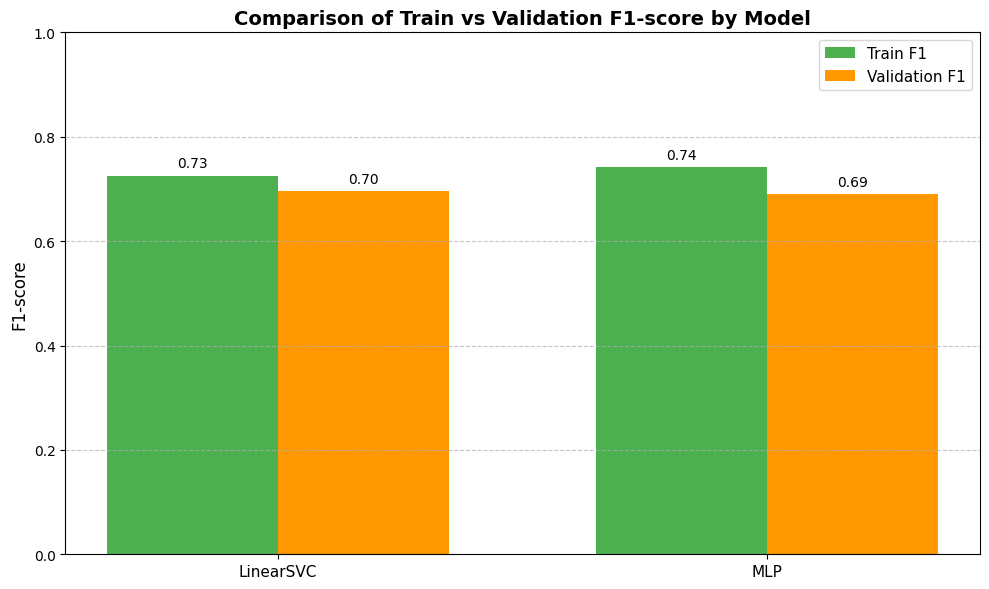

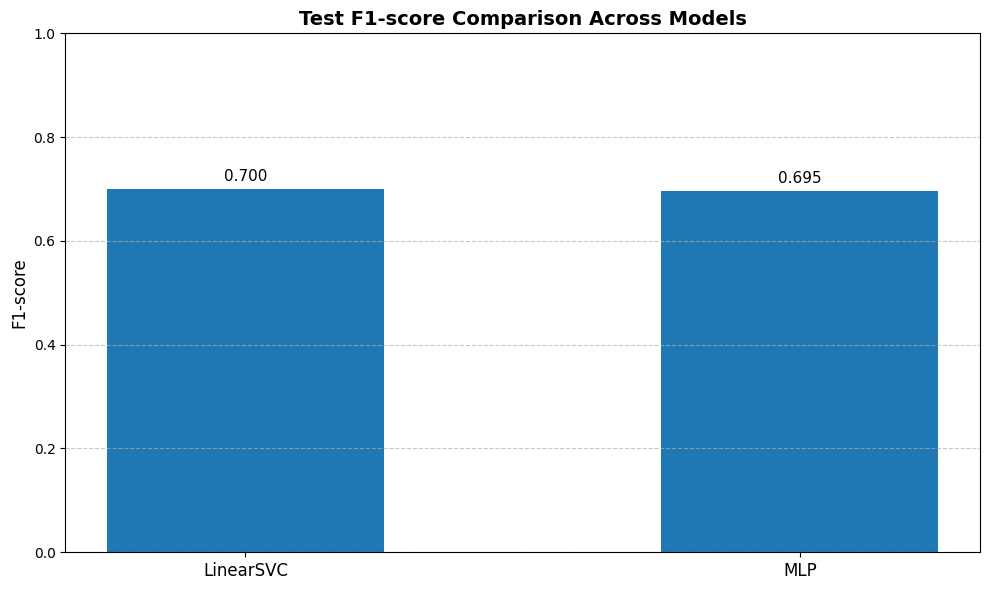

In [52]:
models, train_f1, val_f1, test_f1 = prepare_scores(best_vs_mlp)

plot_train_val(models, train_f1, val_f1)
plot_test(models, test_f1)


L'apport des embeddings BERT aux performances


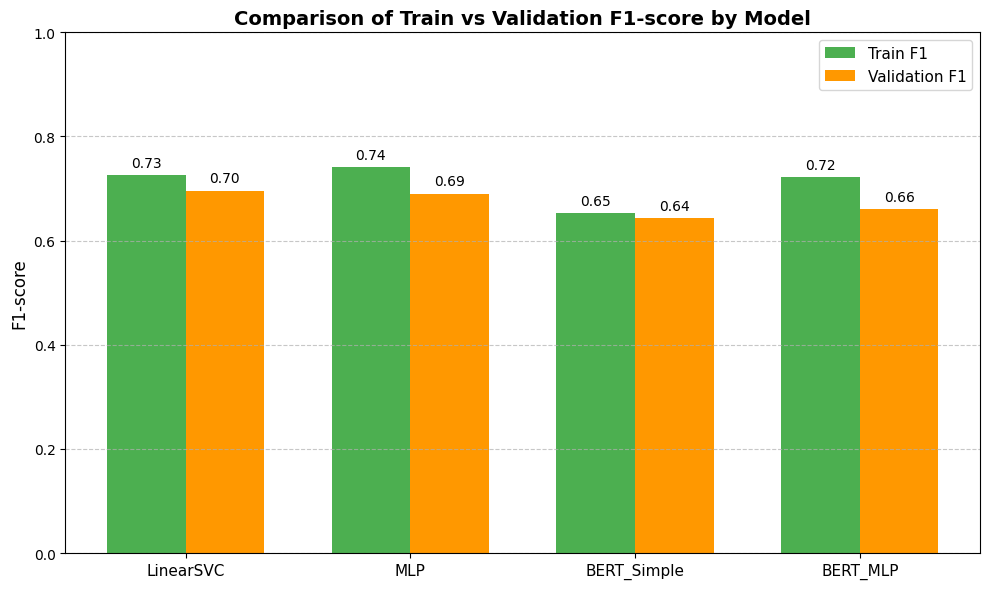

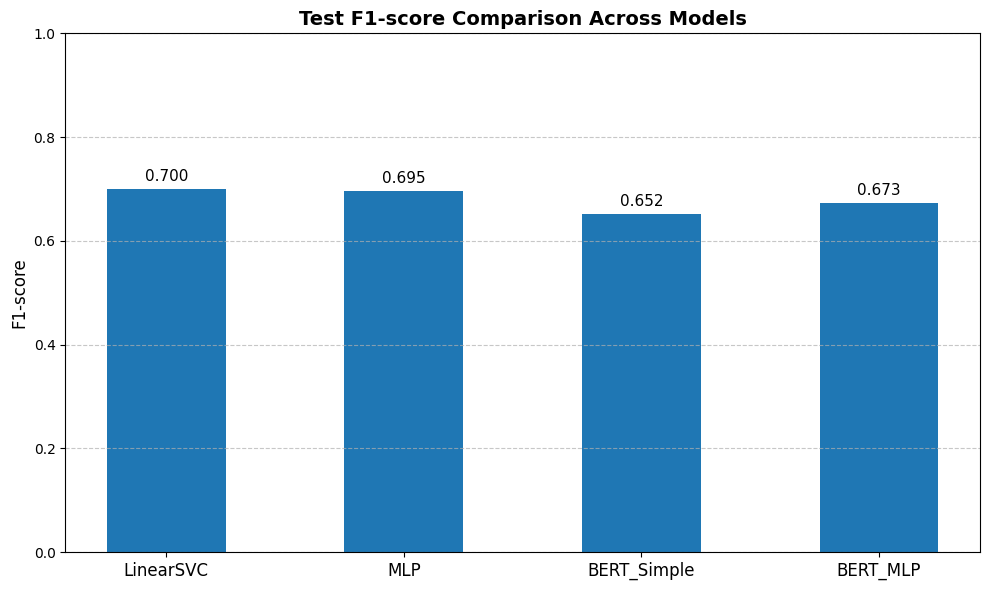

In [53]:
# Comparaison finale : MLP classique + Meilleur classique + 2 BERT
comparison_data = {
    best_classic_model_name: models_score[best_classic_model_name],
    'MLP': models_score['MLP'],
    'BERT_Simple': models_score['BERT_Simple'],
    'BERT_MLP': models_score['BERT_MLP']
}

models, train_f1, val_f1, test_f1 = prepare_scores(comparison_data)

print("="*80)
print("L'apport des embeddings BERT aux performances")
print("="*80)
plot_train_val(models, train_f1, val_f1)
plot_test(models, test_f1)

###Analyse des résultats et comparaison des approches

Les résultats montrent que le MLP classique permet d’atteindre des performances comparables, voire légèrement supérieures, au meilleur modèle classique, confirmant l’intérêt de modèles non linéaires pour ce type de tâche. En revanche, l’utilisation d’embeddings BERT figés n’entraîne pas nécessairement une amélioration des performances, et peut même conduire à une légère dégradation.

Cela s’explique par le fait que les embeddings BERT sont pré-entraînés de manière générique et ne sont pas adaptés spécifiquement à la tâche de classification de sentiment. De plus, l’absence de fine-tuning limite la capacité du modèle à exploiter pleinement la richesse sémantique de BERT. Enfin, sur des jeux de données de taille modérée, des représentations plus simples peuvent généraliser plus efficacement que des embeddings de grande dimension.

## Q4 – Classification du sentiment avec un modèle LLM pré-entraîné

Dans cette section, nous évaluons un modèle LLM pré-entraîné (DistilBERT) directement sur notre tâche de classification de sentiments, sans fine-tuning. L'objectif est de comparer les performances d'un LLM "off-the-shelf" avec les modèles classiques et les approches basées sur embeddings BERT entraînés de zéro.

In [54]:
# Charger le modèle DistilBERT pré-entraîné et évaluer ses performances
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Charger DistilBERT pré-entraîné
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

# Créer les DataLoaders pour DistilBERT (même textes nettoyés)
class TextDatasetDistilBERT(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Créer les datasets et dataloaders
distilbert_train_dataset = TextDatasetDistilBERT(x_train, y_train, distilbert_tokenizer)
distilbert_train_loader = DataLoader(distilbert_train_dataset, batch_size=64, shuffle=False)

distilbert_val_dataset = TextDatasetDistilBERT(x_val, y_val, distilbert_tokenizer)
distilbert_val_loader = DataLoader(distilbert_val_dataset, batch_size=64, shuffle=False)

distilbert_test_dataset = TextDatasetDistilBERT(x_test, y_test, distilbert_tokenizer)
distilbert_test_loader = DataLoader(distilbert_test_dataset, batch_size=64, shuffle=False)

# Fonction pour évaluer le modèle DistilBERT
def evaluate_distilbert(model, train_loader, val_loader, test_loader, device):
    """
    Évalue DistilBERT et retourne les F1-scores pondérés pour train/val/test.
    """
    def get_predictions(model, loader):
        model.eval()
        predictions = []
        targets = []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                targets.extend(batch['label'].cpu().numpy())
                predictions.extend(preds)
        return predictions, targets

    train_pred, train_true = get_predictions(model, train_loader)
    val_pred, val_true = get_predictions(model, val_loader)
    test_pred, test_true = get_predictions(model, test_loader)

    return (
        f1_score(train_true, train_pred, average='weighted'),
        f1_score(val_true, val_pred, average='weighted'),
        f1_score(test_true, test_pred, average='weighted')
    )

# Calculer les F1-scores pour DistilBERT
print("Évaluation de DistilBERT pré-entraîné...")
distilbert_train_f1, distilbert_val_f1, distilbert_test_f1 = evaluate_distilbert(
    distilbert_model, distilbert_train_loader, distilbert_val_loader, distilbert_test_loader, device
)

# Ajouter les scores au dictionnaire principal
models_score['DistilBERT'] = {
    'train_score': distilbert_train_f1,
    'val_score': distilbert_val_f1,
    'test_score': distilbert_test_f1
}

print("\n" + "="*50)
print("DistilBERT Pré-entraîné - F1-scores")
print("="*50)
print(f"Train F1: {distilbert_train_f1:.4f}")
print(f"Val F1: {distilbert_val_f1:.4f}")
print(f"Test F1: {distilbert_test_f1:.4f}")
print("="*50)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Évaluation de DistilBERT pré-entraîné...

DistilBERT Pré-entraîné - F1-scores
Train F1: 0.3153
Val F1: 0.3170
Test F1: 0.3124



COMPARAISON FINALE COMPLÈTE - TOUS LES MODÈLES

Résumé des scores F1 pondérés (Train/Val/Test):

LinearSVC                 | Train: 0.7255 | Val: 0.6962 | Test: 0.6997
MLP                       | Train: 0.7412 | Val: 0.6902 | Test: 0.6953
BERT_MLP                  | Train: 0.7219 | Val: 0.6611 | Test: 0.6727
DistilBERT                | Train: 0.3153 | Val: 0.3170 | Test: 0.3124


Graphiques comparatifs - Tous les modèles:



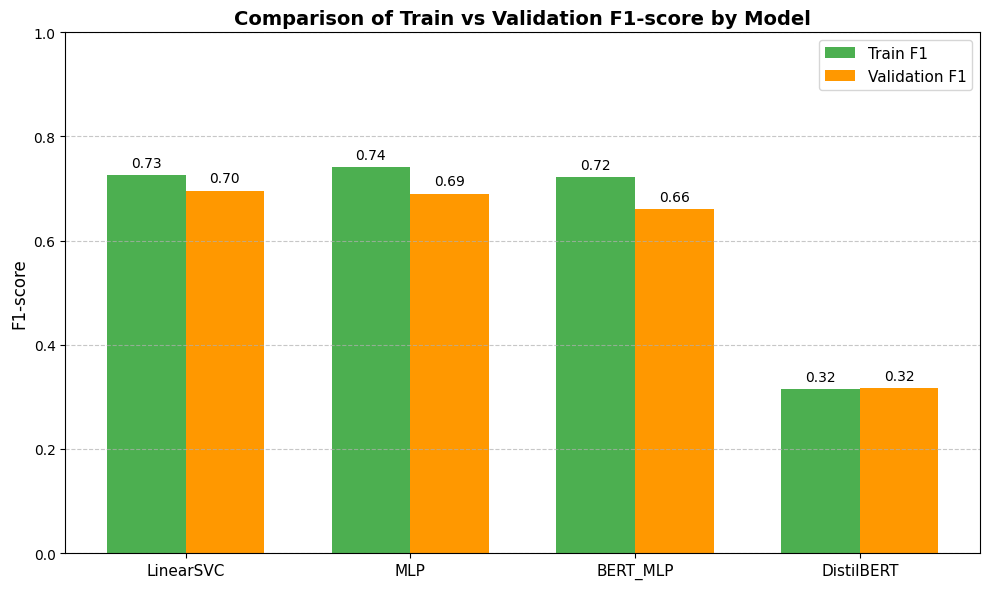

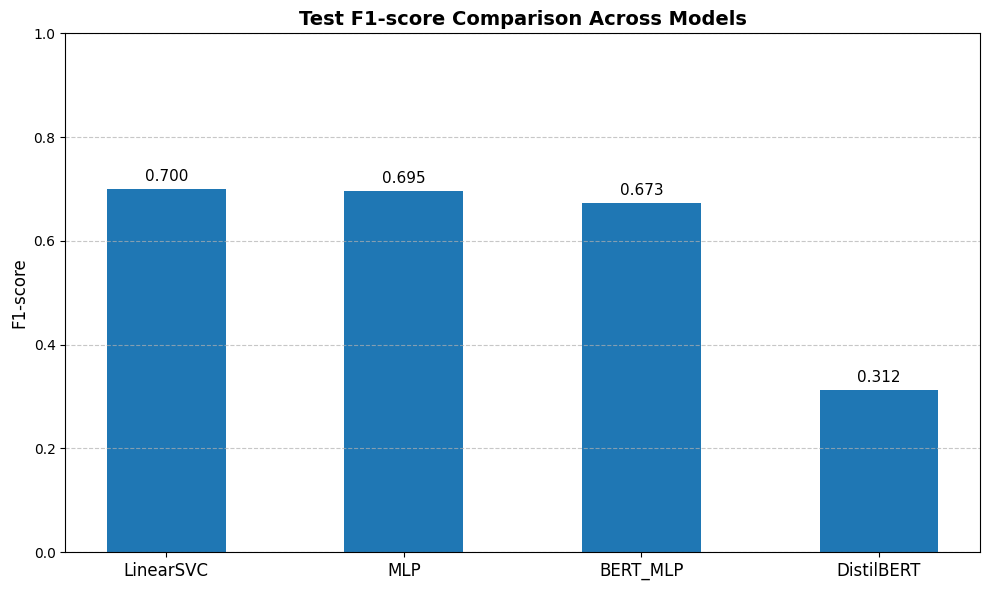

In [55]:
# Comparaison finale de tous les modèles : classiques, BERT embeddings et LLM pré-entraîné
print("\n" + "="*80)
print("COMPARAISON FINALE COMPLÈTE - TOUS LES MODÈLES")
print("="*80)
print("\nRésumé des scores F1 pondérés (Train/Val/Test):\n")

comparison_data = {
    best_classic_model_name: models_score[best_classic_model_name],
    'MLP': models_score['MLP'],
    'BERT_MLP': models_score['BERT_MLP'],
    'DistilBERT': models_score['DistilBERT'],
}

for model_name in comparison_data:
    scores = comparison_data[model_name]
    print(f"{model_name:25} | Train: {scores['train_score']:.4f} | Val: {scores['val_score']:.4f} | Test: {scores['test_score']:.4f}")

print("\n" + "="*80)

# Affichage des graphiques comparatifs
models, train_f1, val_f1, test_f1 = prepare_scores(comparison_data)

print("\nGraphiques comparatifs - Tous les modèles:\n")
plot_train_val(models, train_f1, val_f1)
plot_test(models, test_f1)

Le modèle DistilBERT pré-entraîné sur SST-2 a été optimisé pour une classification binaire (positif/négatif). Or notre dataset comporte trois classes (négatif, neutre, positif). Comme le modèle n’a pas appris la classe neutre, ses prédictions sont biaisées et son score F1 chute fortement. Ce résultat illustre qu’un LLM pré-entraîné, utilisé sans adaptation à la tâche cible, n’est pas nécessairement plus performant qu’un modèle plus simple entraîné spécifiquement sur les données du problème.

##Q5 — Pourquoi choisir un embedding BERT plutôt que le texte brut ? (résumé)

Les embeddings BERT permettent de capturer le sens contextuel des mots (polysemy, dépendances syntaxiques, etc.) contrairement aux vecteurs TF-IDF ou CountVectorizer qui sont bag-of-words et ne tiennent pas compte du contexte.
Une explication plus détaillée est fournie dans le rapport.

##Q6 — Architecture de BERT (résumé)

BERT est un modèle Transformer bidirectionnel utilisant des blocs d’encodeurs. Il apprend le contexte complet d’une phrase via le Masked Language Modeling et la Next Sentence Prediction.
Pour plus de détails, se référer au rapport.

##Q7 — Fine-tuning avec LoRA de modèles LLM pour la classification de sentiment

Dans cette partie, nous effectuons un fine-tuning léger (LoRA) de trois modèles pré-entraînés (RoBERTa, DistilBERT et BERT-base) sur notre dataset de sentiment. L’objectif est de comparer leurs performances après adaptation au contexte de notre tâche, tout en limitant le coût computationnel grâce à LoRA. Nous évaluons ensuite les résultats et comparons avec les modèles classiques et le MLP.

In [56]:
# CHARGEMENT DU MODÈLE ROBERTA + TOKENIZER

MODEL_NAME = "roberta-base"
MAX_LENGTH = 64
NUM_LABELS = 3
BATCH_SIZE = 32



# Charger le tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Charger le modèle
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
)

model = model.to(device)


# Configuration LoRA optimisée pour RoBERTa
lora_config = LoraConfig(
    r=16,                                  # Rang LoRA
    lora_alpha=32,                         # Scaling factor
    target_modules=["query", "key", "value", "dense"],     # Cibles d'adaptation
    lora_dropout=0.1,                      # Dropout LoRA
    bias="none",                           # Pas de biais
    task_type=TaskType.SEQ_CLS            # Classification de séquences
)


# Appliquer LoRA au modèle
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()



# Créer les datasets
train_dataset = TextDataset(x_train,y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(x_val,y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(x_test, y_test, tokenizer, MAX_LENGTH)

# Créer les dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,247,107 || all params: 127,895,046 || trainable%: 2.5389


In [57]:

#  CONFIGURATION DE L'ENTRAÎNEMENT

# Hyperparamètres
NUM_EPOCHS = 5
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0

# Optimizer et scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    eps=1e-8
)

# Nombre total d'étapes
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * 0.1)  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()




# FONCTIONS D'ÉVALUATION

def evaluate(model, data_loader, device, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Récupérer les prédictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculer les métriques
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1, all_preds, all_labels

In [59]:
# BOUCLE D'ENTRAÎNEMENT

# Variables pour suivi
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

patience = 2
patience_counter = 0
best_val_f1 = 0
best_model_state = None

# Boucle d'entraînement
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*80}")

    # PHASE D'ENTRAÎNEMENT
    model.train()
    train_loss = 0
    train_preds = []
    train_labels_list = []

    progress_bar = range(len(train_loader))
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()

        # Récupérer les prédictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().detach().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        # Affichage du progrès
        if (batch_idx + 1) % 50 == 0:
            avg_loss = train_loss / (batch_idx + 1)
            print(f"  Batch {batch_idx + 1}/{len(train_loader)} - Loss: {avg_loss:.4f}")



    # Métriques d'entraînement
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')

    train_losses.append(avg_train_loss)

    print(f"\n Train Loss: {avg_train_loss:.4f}")
    print(f" Train Accuracy: {train_accuracy:.4f}")
    print(f" Train F1-Score: {train_f1:.4f}")

    # PHASE DE VALIDATION
    print(f"\nValidation...")
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device, loss_fn)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f" Val Loss: {val_loss:.4f}")
    print(f" Val Accuracy: {val_acc:.4f}")
    print(f" Val F1-Score: {val_f1:.4f}")

    # Sauvegarder le meilleur modèle
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        print(f" Nouveau meilleur modèle trouvé F1-Score: {val_f1:.4f}")

print("\n" + "="*80)
print("ENTRAÎNEMENT TERMINÉ")



Epoch 1/5
  Batch 50/687 - Loss: 1.1033
  Batch 100/687 - Loss: 1.0925
  Batch 150/687 - Loss: 0.9814
  Batch 200/687 - Loss: 0.8996
  Batch 250/687 - Loss: 0.8406
  Batch 300/687 - Loss: 0.8000
  Batch 350/687 - Loss: 0.7675
  Batch 400/687 - Loss: 0.7449
  Batch 450/687 - Loss: 0.7251
  Batch 500/687 - Loss: 0.7086
  Batch 550/687 - Loss: 0.6971
  Batch 600/687 - Loss: 0.6848
  Batch 650/687 - Loss: 0.6773

 Train Loss: 0.6678
 Train Accuracy: 0.7021
 Train F1-Score: 0.7035

Validation...
 Val Loss: 0.5713
 Val Accuracy: 0.7860
 Val F1-Score: 0.7840
 Nouveau meilleur modèle trouvé F1-Score: 0.7840

Epoch 2/5
  Batch 50/687 - Loss: 0.4883
  Batch 100/687 - Loss: 0.4906
  Batch 150/687 - Loss: 0.5046
  Batch 200/687 - Loss: 0.5040
  Batch 250/687 - Loss: 0.5026
  Batch 300/687 - Loss: 0.4966
  Batch 350/687 - Loss: 0.4964
  Batch 400/687 - Loss: 0.4974
  Batch 450/687 - Loss: 0.4987
  Batch 500/687 - Loss: 0.4978
  Batch 550/687 - Loss: 0.5011
  Batch 600/687 - Loss: 0.4983
  Batch 65

In [60]:
# CHARGER LE MEILLEUR MODÈLE ET ÉVALUER

# Charger le meilleur modèle
if best_model_state:
    model.load_state_dict(best_model_state)
    print(" Meilleur modèle chargé")

# Évaluer sur le test set
print("\nÉvaluation sur le Test Set...")
roberta_test_loss, roberta_test_acc, roberta_test_f1, test_preds, test_labels_true = evaluate(
    model, test_loader, device, loss_fn
)

print(f"\n{'='*80}")
print("ROBERTA RÉSULTATS FINAUX")
print(f"{'='*80}")
print(f"Test Loss: {roberta_test_loss:.4f}")
print(f"Test Accuracy: {roberta_test_acc:.4f}")
print(f"Test F1-Score (weighted): {roberta_test_f1:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(
    test_labels_true,
    test_preds,
    target_names=['negative', 'neutral', 'positive']
))

 Meilleur modèle chargé

Évaluation sur le Test Set...

ROBERTA RÉSULTATS FINAUX
Test Loss: 0.5555
Test Accuracy: 0.7949
Test F1-Score (weighted): 0.7948

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.81      0.79      1001
     neutral       0.77      0.75      0.76      1430
    positive       0.85      0.83      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.80      0.80      3534
weighted avg       0.80      0.79      0.79      3534



In [61]:
# ENTRAÎNEMENT: BERT-BASE avec LoRA


# 1. Charger BERT et tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
).to(device)

# 2. Appliquer LoRA
bert_lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value", "key"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
bert_model = get_peft_model(bert_model, bert_lora_config)

bert_model.print_trainable_parameters()

# 3. Créer datasets
from torch.utils.data import DataLoader

bert_train_dataset =TextDataset(x_train,y_train, bert_tokenizer, MAX_LENGTH)
bert_val_dataset =TextDataset(x_val,y_val, bert_tokenizer, MAX_LENGTH)
bert_test_dataset =TextDataset(x_test,y_test, bert_tokenizer, MAX_LENGTH)

bert_train_loader = DataLoader(bert_train_dataset, batch_size=32, shuffle=True)
bert_val_loader = DataLoader(bert_val_dataset, batch_size=32)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=32)

# 4. Optimizer et Scheduler
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-4, weight_decay=0.01)
bert_total_steps = len(bert_train_loader) * 5
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=int(bert_total_steps * 0.1),
    num_training_steps=bert_total_steps
)

# 5. Entraînement BERT
loss_fn = torch.nn.CrossEntropyLoss()
best_bert_f1 = 0

for epoch in range(5):
    bert_model.train()
    bert_train_loss = 0

    for batch in bert_train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        bert_optimizer.zero_grad()
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        bert_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()

    # Validation
    bert_val_loss, bert_val_acc, bert_val_f1, _, _ = evaluate(bert_model, bert_val_loader, device, loss_fn)

    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/5 | Train Loss: {bert_train_loss/len(bert_train_loader):.4f} | Val F1: {bert_val_f1:.4f}")

    if bert_val_f1 > best_bert_f1:
        best_bert_f1 = bert_val_f1

# Test BERT
bert_test_loss, bert_test_acc, bert_test_f1, bert_test_preds, bert_test_labels = evaluate(
    bert_model, bert_test_loader, device, loss_fn
)

print(f"\n BERT Test F1-Score: {bert_test_f1:.4f}")
print(f"   Accuracy: {bert_test_acc:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,043 || all params: 110,371,590 || trainable%: 0.8037
Epoch 1/5 | Train Loss: 0.7529 | Val F1: 0.7579
Epoch 2/5 | Train Loss: 0.5412 | Val F1: 0.7833
Epoch 3/5 | Train Loss: 0.4965 | Val F1: 0.7894
Epoch 4/5 | Train Loss: 0.4643 | Val F1: 0.7871
Epoch 5/5 | Train Loss: 0.4436 | Val F1: 0.7896

 BERT Test F1-Score: 0.7947
   Accuracy: 0.7946


In [62]:
# ENTRAÎNEMENT: DistilBERT avec LoRA (léger)

# 1. Charger DistilBERT et tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=NUM_LABELS
).to(device)

# 2. Appliquer LoRA (rang réduit pour modèle plus petit)
distilbert_lora_config = LoraConfig(
    r=8,  # Rang réduit pour DistilBERT (66M params vs 125M pour BERT)
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],  # DistilBERT a des noms différents pour les couches linéaires
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
distilbert_model = get_peft_model(distilbert_model, distilbert_lora_config)

distilbert_model.print_trainable_parameters()

# 3. Créer datasets
distilbert_train_dataset = TextDataset(x_train,y_train, distilbert_tokenizer, MAX_LENGTH)
distilbert_val_dataset = TextDataset(x_val,y_val, distilbert_tokenizer, MAX_LENGTH)
distilbert_test_dataset =TextDataset(x_test,y_test, distilbert_tokenizer, MAX_LENGTH)

distilbert_train_loader = DataLoader(distilbert_train_dataset, batch_size=32, shuffle=True)
distilbert_val_loader = DataLoader(distilbert_val_dataset, batch_size=32)
distilbert_test_loader = DataLoader(distilbert_test_dataset, batch_size=32)

# 4. Optimizer et Scheduler
distilbert_optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr=2e-4, weight_decay=0.01)
distilbert_total_steps = len(distilbert_train_loader) * 5
distilbert_scheduler = get_linear_schedule_with_warmup(
    distilbert_optimizer,
    num_warmup_steps=int(distilbert_total_steps * 0.1),
    num_training_steps=distilbert_total_steps
)

# 5. Entraînement DistilBERT
best_distilbert_f1 = 0

for epoch in range(5):
    distilbert_model.train()
    distilbert_train_loss = 0

    for batch in distilbert_train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        distilbert_optimizer.zero_grad()
        outputs = distilbert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        distilbert_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(distilbert_model.parameters(), 1.0)
        distilbert_optimizer.step()
        distilbert_scheduler.step()

    # Validation
    distilbert_val_loss, distilbert_val_acc, distilbert_val_f1, _, _ = evaluate(
        distilbert_model, distilbert_val_loader, device, loss_fn
    )

    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/5 | Train Loss: {distilbert_train_loss/len(distilbert_train_loader):.4f} | Val F1: {distilbert_val_f1:.4f}")

    if distilbert_val_f1 > best_distilbert_f1:
        best_distilbert_f1 = distilbert_val_f1

# Test DistilBERT
distilbert_test_loss, distilbert_test_acc, distilbert_test_f1, distilbert_test_preds, distilbert_test_labels = evaluate(
    distilbert_model, distilbert_test_loader, device, loss_fn
)

print(f"\n DistilBERT Test F1-Score: {distilbert_test_f1:.4f}")
print(f"   Accuracy: {distilbert_test_acc:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 740,355 || all params: 67,696,134 || trainable%: 1.0936
Epoch 1/5 | Train Loss: 0.7187 | Val F1: 0.7666
Epoch 2/5 | Train Loss: 0.5575 | Val F1: 0.7820
Epoch 3/5 | Train Loss: 0.5272 | Val F1: 0.7851
Epoch 4/5 | Train Loss: 0.5016 | Val F1: 0.7933
Epoch 5/5 | Train Loss: 0.4859 | Val F1: 0.7921

 DistilBERT Test F1-Score: 0.7860
   Accuracy: 0.7858


In [63]:
#  ENSEMBLE VOTING: RoBERTa + BERT + DistilBERT

def ensemble_3models_prediction(text, roberta_model, bert_model, distilbert_model,
                                 roberta_tokenizer, bert_tokenizer, distilbert_tokenizer,
                                 device, weights=[0.35, 0.35, 0.30]):
    """Prédiction d'ensemble avec 3 modèles (vote pondéré) """

    roberta_model.eval()
    bert_model.eval()
    distilbert_model.eval()

    with torch.no_grad():
        # Prédiction RoBERTa
        inputs_r = roberta_tokenizer(text, return_tensors='pt',
                                     padding='max_length', max_length=MAX_LENGTH,
                                     truncation=True).to(device)
        outputs_r = roberta_model(**inputs_r)
        probs_r = torch.softmax(outputs_r.logits, dim=-1).cpu().numpy()[0]

        # Prédiction BERT
        inputs_b = bert_tokenizer(text, return_tensors='pt',
                                 padding='max_length', max_length=MAX_LENGTH,
                                 truncation=True).to(device)
        outputs_b = bert_model(**inputs_b)
        probs_b = torch.softmax(outputs_b.logits, dim=-1).cpu().numpy()[0]

        # Prédiction DistilBERT
        inputs_d = distilbert_tokenizer(text, return_tensors='pt',
                                       padding='max_length', max_length=MAX_LENGTH,
                                       truncation=True).to(device)
        outputs_d = distilbert_model(**inputs_d)
        probs_d = torch.softmax(outputs_d.logits, dim=-1).cpu().numpy()[0]

    # Moyenne pondérée des probabilités
    ensemble_probs = weights[0] * probs_r + weights[1] * probs_b + weights[2] * probs_d
    ensemble_pred = np.argmax(ensemble_probs)

    return ensemble_pred, ensemble_probs

# Évaluation sur le test set

# les modèles sont en mode évaluation
model.eval() # RoBERTa
bert_model.eval()
distilbert_model.eval()

ensemble_preds = []
ensemble_probs_list = []

# Itérer sur les textes du jeu de test et obtenir les prédictions d'ensemble
for text in x_test:
    pred, probs = ensemble_3models_prediction(
        text, model, bert_model, distilbert_model,
        tokenizer, bert_tokenizer, distilbert_tokenizer,
        device,
        weights=[0.5, 0.35, 0.15] # Poids pour RoBERTa, BERT, DistilBERT respectivement
    )
    ensemble_preds.append(pred)
    ensemble_probs_list.append(probs)

ensemble_preds = np.array(ensemble_preds)

# Calculer les métriques F1-Score et Accuracy pour l'ensemble
ensemble_f1 = f1_score(test_labels_true, ensemble_preds, average='weighted')
ensemble_acc = accuracy_score(test_labels_true, ensemble_preds)

print(f"\n RÉSULTATS ENSEMBLE 3 modèles - Vote Pondéré):")
print(f"   F1-Score: {ensemble_f1:.4f}")
print(f"   Accuracy: {ensemble_acc:.4f}")

# Comparaison des résultats avec les modèles individuels
print(f"\n COMPARAISON DES RÉSULTATS INDIVIDUELS ET ENSEMBLE:")
print(f"   RoBERTa F1-Score:      {roberta_test_f1:.4f}")
print(f"   RoBERTa Accuracy:      {roberta_test_acc:.4f}")
print(f"   BERT F1-Score:         {bert_test_f1:.4f}")
print(f"   BERT Accuracy:         {bert_test_acc:.4f}")
print(f"   DistilBERT F1-Score:   {distilbert_test_f1:.4f}")
print(f"   DistilBERT Accuracy:   {distilbert_test_acc:.4f}")
print(f"   ENSEMBLE F1-Score:     {ensemble_f1:.4f} ")
print(f"   ENSEMBLE Accuracy:     {ensemble_acc:.4f} ")

# Calcul du gain par rapport à RoBERTa (le premier modèle entraîné)
gain = (ensemble_f1 - roberta_test_f1) * 100


 RÉSULTATS ENSEMBLE 3 modèles - Vote Pondéré):
   F1-Score: 0.8069
   Accuracy: 0.8067

 COMPARAISON DES RÉSULTATS INDIVIDUELS ET ENSEMBLE:
   RoBERTa F1-Score:      0.7948
   RoBERTa Accuracy:      0.7949
   BERT F1-Score:         0.7947
   BERT Accuracy:         0.7946
   DistilBERT F1-Score:   0.7860
   DistilBERT Accuracy:   0.7858
   ENSEMBLE F1-Score:     0.8069 
   ENSEMBLE Accuracy:     0.8067 
